<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/seismic/seis_fluidfactor_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates generation of Fluid Factor attribute given near and far stack 3D seismic data of Volve field. Inline 10191 is target for our analysis.

In [ ]:
# Install, import packages, and clone repository
import numpy as np
import matplotlib.pyplot as plt

!pip -q install segyio
!pip -q install azure-cli
import segyio
import sys

!git clone https://github.com/yohanesnuwara/computational-geophysics
sys.path.append('/content/computational-geophysics/seismic')

# from seis_attribute import display_attribute
from seistool import openSegy3D, sliceCube, sliceFluidFactor, plot2D

To access near and far stack data, we retrieve data directly from Azure Storage. If you have accessed before, you get the SAS token. Run the following function to retrieve the data. Note that SAS token is expired every 30 days, so if you failed to run it, make sure you have renewed your access.

In [2]:
def get_file_azure(sastoken, filepath, to_filename):
  """
  Download Files from Microsoft Azure Storage

  INPUT:

  sastoken: SAS token (from 'sv' to 'sp=rl')
  filepath: Directory of file in Azure
  to_filename: The wanted name for file

  OUTPUT:

  File will be downloaded in the system
  """
  import sys
  import os  
  
  if not os.path.exists(to_filename):
      !{sys.executable} -m azure.cli storage blob download \
          --account-name datavillagesa \
          --container-name volve \
          --name "{filepath}" \
          --file "{to_filename}" \
          --sas-token "{sastoken}"  

In [ ]:
# Get Near stack data
sastoken = "your token here ..."
filepath = "Seismic/ST0202/Stacks/ST0202R08_PZ_PSDM_NEAR_OFFSET_PP_TIME.MIG_FIN.POST_STACK.3D.JS-017534.segy"
to_filename = "VolveNear.sgy"

get_file_azure(sastoken, filepath, to_filename)

In [ ]:
# Get Far stack data
sastoken = "your token here ..."
filepath = "Seismic/ST0202/Stacks/ST0202R08_PZ_PSDM_FAR_OFFSET_PP_TIME.MIG_FIN.POST_STACK.3D.JS-017534.segy"
to_filename = "VolveFar.sgy"

get_file_azure(sastoken, filepath, to_filename)

Open Segy data.

In [5]:
near, far = openSegy3D("/content/VolveNear.sgy"), openSegy3D("/content/VolveFar.sgy")

Successfully read 

Inline range from 9985 to 10369
Crossline range from 1932 to 2536
TWT from 0.0 to 4500.0
Sample rate: 4.0 ms
Survey rotation: 4.96 deg
Successfully read 

Inline range from 9985 to 10369
Crossline range from 1932 to 2536
TWT from 0.0 to 4500.0
Sample rate: 4.0 ms
Survey rotation: 4.96 deg


Display near and far stacks.

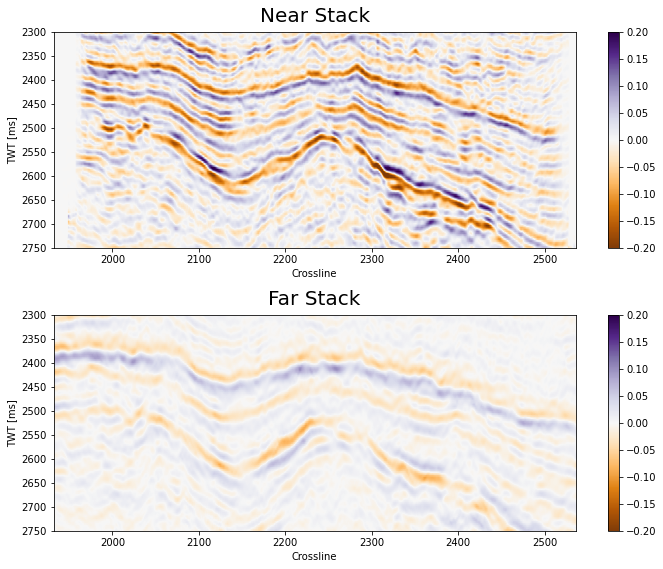

In [6]:
# Make slices inline 10191
near_sl = sliceCube(near, 'il', inline_loc=10191)
far_sl = sliceCube(far, 'il', inline_loc=10191)

# Plot stacks
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plot2D(near_sl.T, near, 'il', cmap='PuOr', vmin=-0.2, vmax=0.2)
plt.title("Near Stack", size=20, pad=10)
plt.xlabel("Crossline"); plt.ylabel("TWT [ms]")
plt.ylim(2750,2300)

plt.subplot(2,1,2)
plot2D(far_sl.T, near, 'il', cmap='PuOr', vmin=-0.2, vmax=0.2)
plt.title("Far Stack", size=20, pad=10)
plt.xlabel("Crossline"); plt.ylabel("TWT [ms]")
plt.ylim(2750,2300)

plt.tight_layout(1.05)
plt.show()

Fluid Factor is approximated by doing a linear regression on the **amplitude difference between far and near stack** ($y$) vs. **near stack amplitude** ($x$) crossplot.

$$y=\alpha \cdot x$$

$$FF=y- \alpha \cdot x$$

Where $\alpha$ is slope of regressed line.

We have already had this calculation inside `seistool`. Let us first display the crossplot and regressed line. Analysis only on Inline 10191.

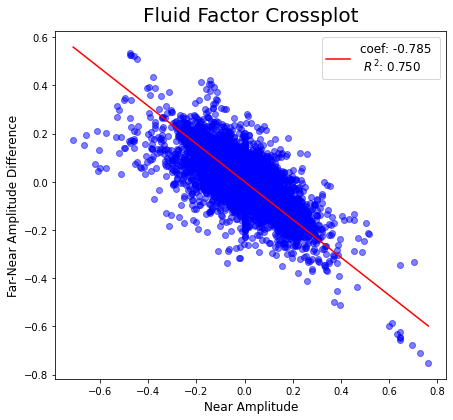

In [7]:
sliceFluidFactor(near, far, 'il', inline_loc=10191, crossplot=True)

The slope of regressed line $\alpha$ is -0.785. Next, compute Fluid Factor. 

In [8]:
FF = sliceFluidFactor(near, far, 'il', inline_loc=10191)

Finally plot the computed Fluid Factor on inline 10191.

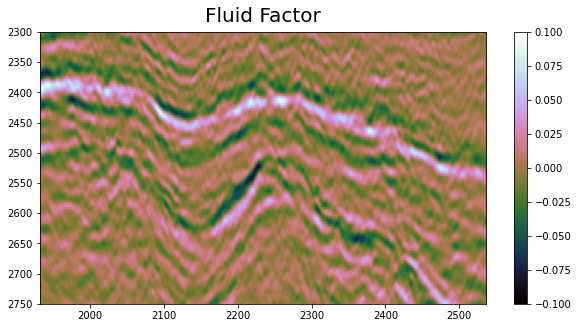

In [13]:
# Plot calculated fluid factor
plt.figure(figsize=(10,5))
plot2D(FF.T, near, 'il', cmap='cubehelix', vmin=-.1, vmax=.1)
plt.title('Fluid Factor', size=20, pad=10)
plt.ylim(2750,2300)
plt.show()

We see positive large (0.025 to 0.05) and negative large (-0.05 to -0.025) Fluid Factor, white and green color respectively. Negative large FF can associate with top of gas sand, and positive large FF can associate with bottom of gas sand ([CREWES Report](https://www.crewes.org/ForOurSponsors/ResearchReports/2010/CRR201002.pdf)). Therefore, between these layers, there may be gas. The background has FF near zero (-0.025 to 0.025) is water-bearing zones.

Plot near stack, far stack, and Fluid Factor altogether.

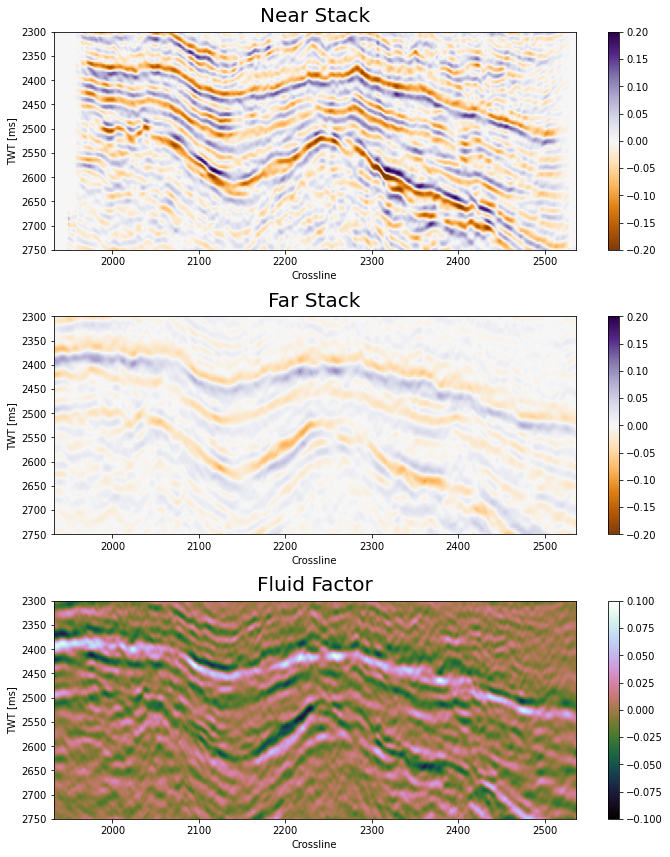

In [14]:
# Make slices inline 10191
near_sl = sliceCube(near, 'il', inline_loc=10191)
far_sl = sliceCube(far, 'il', inline_loc=10191)

# Plot stacks
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plot2D(near_sl.T, near, 'il', cmap='PuOr', vmin=-0.2, vmax=0.2)
plt.title("Near Stack", size=20, pad=10)
plt.xlabel("Crossline"); plt.ylabel("TWT [ms]")
plt.ylim(2750,2300)

plt.subplot(3,1,2)
plot2D(far_sl.T, near, 'il', cmap='PuOr', vmin=-0.2, vmax=0.2)
plt.title("Far Stack", size=20, pad=10)
plt.xlabel("Crossline"); plt.ylabel("TWT [ms]")
plt.ylim(2750,2300)

plt.subplot(3,1,3)
plot2D(FF.T, near, 'il', cmap='cubehelix', vmin=-0.1, vmax=0.1)
plt.title("Fluid Factor", size=20, pad=10)
plt.xlabel("Crossline"); plt.ylabel("TWT [ms]")
plt.ylim(2750,2300)

plt.tight_layout(1.05)
plt.show()